# 🛡️ Credit Card Fraud Analysis (Amex Dataset)

This notebook demonstrates an end-to-end fraud risk analysis pipeline inspired by FinTech practices using the Amex Kaggle dataset.

## 🔍 Project Steps
1. Load and preprocess the dataset
2. Feature engineering and aggregation
3. Model training and evaluation
4. Visualization and explainability (SHAP)

---
| Feature                   | Description                             | Likely Source             | New User? |
| ------------------------- | --------------------------------------- | ------------------------- | --------- |
| `customer_id`             | Unique ID                               | System-generated          | ✅ Yes     |
| `name`                    | Applicant name                          | Self-declared             | ✅ Yes     |
| `age`                     | User’s age                              | Self-declared / ID        | ✅ Yes     |
| `gender`                  | Gender                                  | Self-declared             | ✅ Yes     |
| `owns_car`                | Whether owns a car                      | Self-declared             | ✅ Yes     |
| `owns_house`              | Whether owns a house                    | Self-declared             | ✅ Yes     |
| `no_of_children`          | Number of children                      | Self-declared             | ✅ Yes     |
| `net_yearly_income`       | Net yearly income                       | Self-declared / Verified  | ✅ Yes     |
| `no_of_days_employed`     | Days employed                           | Self-declared or sourced  | ✅ Yes     |
| `occupation_type`         | Job category                            | Self-declared             | ✅ Yes     |
| `total_family_members`    | Household size                          | Self-declared             | ✅ Yes     |
| `migrant_worker`          | Whether migrant                         | Self-declared or detected | ✅ Yes     |
| `yearly_debt_payments`    | Existing yearly debt repayments         | 📈 Financial behavior     | ❌ No      |
| `credit_limit`            | Credit limit of existing card/account   | Bank product data         | ❌ No      |
| `credit_limit_used(%)`    | Current credit usage rate               | Transactional behavior    | ❌ No      |
| `credit_score`            | Score based on financial/credit history | Bureau-calculated         | ❌ No      |
| `prev_defaults`           | Number of prior defaults                | Internal/bureau history   | ❌ No      |
| `default_in_last_6months` | Recent default flag                     | Behavioral history        | ❌ No      |


🆕 New User Features (can be used at signup):
These features can be used to build a new user model:

Age, Gender, Owns Car, Owns House

Income, Occupation Type, Employment Days

Family Info, Migrant Status

⚠️ Caveat: Many of these can be easily manipulated, so risk detection should also account for possible inconsistencies, proxies, or external verification (e.g. KYC, payslips, address match).

🧓 Existing User Features:
Only available after relationship or bureau check:

Credit score, past defaults, credit limit

Repayment behavior

Utilization metrics

These are critical for high-accuracy scoring but not available for new applicants.


In [50]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import lightgbm as lgb
import shap
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# Load Dataset and Inspect data
train = pd.read_csv('/content/drive/MyDrive/Amex/train.csv')
train.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


In [52]:
# Check the target column
train['credit_card_default'].value_counts(normalize=True)

,proportion
credit_card_default,
0,0.918797
1,0.081203


In [53]:
test = pd.read_csv('/content/drive/MyDrive/Amex/test.csv')
test.head()

,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months
0,CST_142525,Siva,52,F,Y,N,0.0,232640.53,998.0,Unknown,2.0,0.0,14406.73,26524.40,4,779.0,0,0
1,CST_129215,Scott,48,F,N,N,1.0,284396.79,1338.0,Unknown,3.0,0.0,57479.99,68998.72,70,806.0,0,0
2,CST_138443,Victoria,50,F,N,N,1.0,149419.28,1210.0,Unknown,3.0,0.0,21611.01,25187.80,71,528.0,2,0
3,CST_123812,John McCrank,30,F,N,N,1.0,160437.54,503.0,Laborers,2.0,1.0,28990.76,29179.39,9,815.0,0,0
4,CST_144450,Martinne,52,M,N,Y,0.0,233480.37,157.0,Laborers,2.0,1.0,54213.72,82331.82,82,613.0,1,1


In [54]:
#Preprocess data
# Start with a clean copy
df = train.copy()

# Drop unnecessary ID columns
df = df.drop(columns=['customer_id', 'name'], errors='ignore')

# Manually define categorical and numeric columns
categorical_cols = ['gender', 'owns_car', 'owns_house', 'occupation_type', 'migrant_worker']
numeric_cols = [
    'age', 'no_of_children', 'net_yearly_income', 'no_of_days_employed',
    'total_family_members', 'yearly_debt_payments', 'credit_limit',
    'credit_limit_used(%)', 'credit_score', 'prev_defaults', 'default_in_last_6months'
]

# Target column
target_col = 'credit_card_default'

In [55]:
# Apply Label Encoding
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
    df[col] = df[col].astype(str).fillna("Unknown")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [56]:
df.head()

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,46,0,0,1,0.0,107934.04,612.0,17,1.0,1,33070.28,18690.93,73,544.0,2,1,1
1,29,1,0,1,0.0,109862.62,2771.0,8,2.0,0,15329.53,37745.19,52,857.0,0,0,0
2,37,1,0,1,0.0,230153.17,204.0,8,2.0,0,48416.60,41598.36,43,650.0,0,0,0
3,39,0,0,1,0.0,122325.82,11941.0,3,2.0,0,22574.36,32627.76,20,754.0,0,0,0
4,46,1,1,1,0.0,387286.00,1459.0,3,1.0,0,38282.95,52950.64,75,927.0,0,0,0


In [57]:
import joblib

# Save each LabelEncoder
for col, le in label_encoders.items():
    joblib.dump(le, f"le_{col}.pkl")

In [58]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

print("Final dataset shape:", df.shape)
print("Any missing values left?", df.isnull().sum().sum())  # should be 0

Final dataset shape: (45528, 17)
Any missing values left? 0


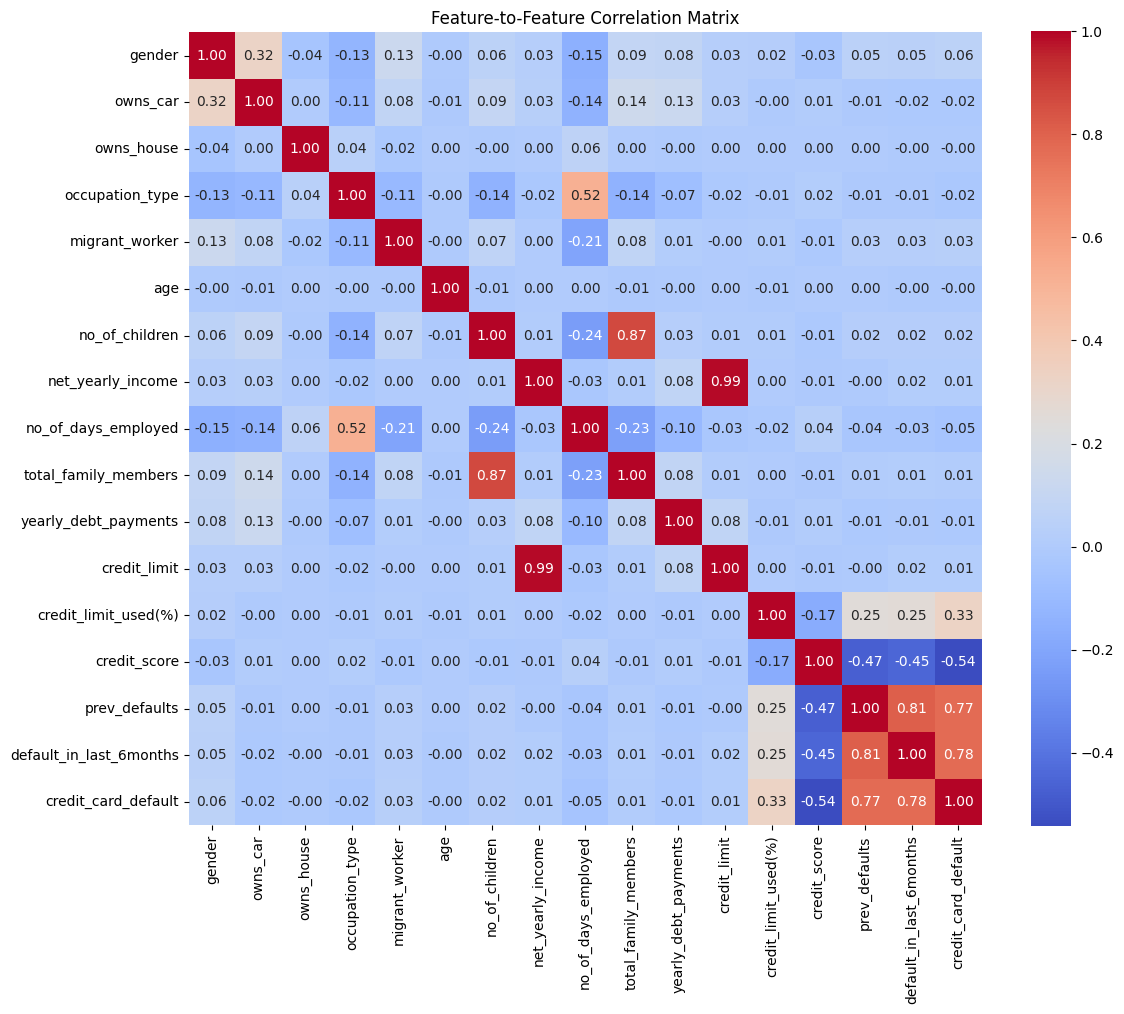

In [59]:
# Correlation matrix
corr_matrix_full = df[categorical_cols + numeric_cols+ ['credit_card_default']].corr()

# Plot full heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_full, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Feature-to-Feature Correlation Matrix")
plt.tight_layout()
plt.show()

We can see only credit_limit, credit_score, pre_defaults,default_in_last_6_months have strong linear relationship with credit_card_default. We did not capture any new user features obviously for credit_card_default. Maybe there are none linear relationship or no relationship at all.
Nest step, we are going to build a New User Credit Model.

## Phase 1: Build Level 1 – New User Credit Model

In [80]:
#Step 1: Select "basic info only" features
"""
basic_features = [
    'age', 'gender', 'owns_car', 'owns_house',
    'occupation_type','no_of_days_employed',
    'net_yearly_income', 'total_family_members',
    'migrant_worker']
"""
basic_features=['age', 'net_yearly_income', 'occupation_type', 'no_of_days_employed','owns_house','total_family_members']
X_new = df[basic_features].copy()
y_new = df['credit_card_default']

In [87]:
X_new.head()

,age,net_yearly_income,occupation_type,no_of_days_employed,owns_house,total_family_members,log_income,log_days_employed,income_per_member,is_home_owner
0,46.0,107934.04,17,612.0,1,1.0,11.589285,6.418365,53967.020000,1
1,29.0,109862.62,8,2771.0,1,2.0,11.606995,7.927324,36620.873333,1
2,37.0,230153.17,8,204.0,1,2.0,12.346505,5.323010,76717.723333,1
3,39.0,122325.82,3,11941.0,1,2.0,11.714452,9.387817,40775.273333,1
4,46.0,387286.00,3,1459.0,1,1.0,12.866921,7.286192,193643.000000,1


In [88]:
# Model A
from lightgbm import LGBMClassifier

# Log transform to reduce skewness
X_new['log_income'] = np.log1p(X_new['net_yearly_income'])
X_new['log_days_employed'] = np.log1p(X_new['no_of_days_employed'])

# Income per family member
X_new['income_per_member'] = X_new['net_yearly_income'] / (X_new['total_family_members'] + 1)

# Binary features
X_new['is_home_owner'] = X_new['owns_house'].map({1: 1, 0: 0})

from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Impute missing
imputer = SimpleImputer(strategy='median')
#X_imputed = imputer.fit_transform(X_new)
# Reassign feature names after imputation
X_imputed = pd.DataFrame(imputer.fit_transform(X_new), columns=X_new.columns)


# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y_new)

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42)


model_new_A = LGBMClassifier(class_weight='balanced', random_state=42)

model_new_A.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 33465, number of negative: 33464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 66929, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [85]:
#Evaluate
y_pred_new = model_new_A.predict(X_val)
y_prob_new = model_new_A.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred_new))
print("New User AUC:", roc_auc_score(y_val, y_prob_new))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      8367
           1       1.00      0.90      0.95      8366

    accuracy                           0.95     16733
   macro avg       0.95      0.95      0.95     16733
weighted avg       0.95      0.95      0.95     16733

New User AUC: 0.9632909986042237


In [89]:
# Just before model_new_A.fit()
expected_new_user_columns = X_train.columns.tolist()
joblib.dump(expected_new_user_columns, "expected_new_user_columns.pkl")
print(expected_new_user_columns)

['age', 'net_yearly_income', 'occupation_type', 'no_of_days_employed', 'owns_house', 'total_family_members', 'log_income', 'log_days_employed', 'income_per_member', 'is_home_owner']


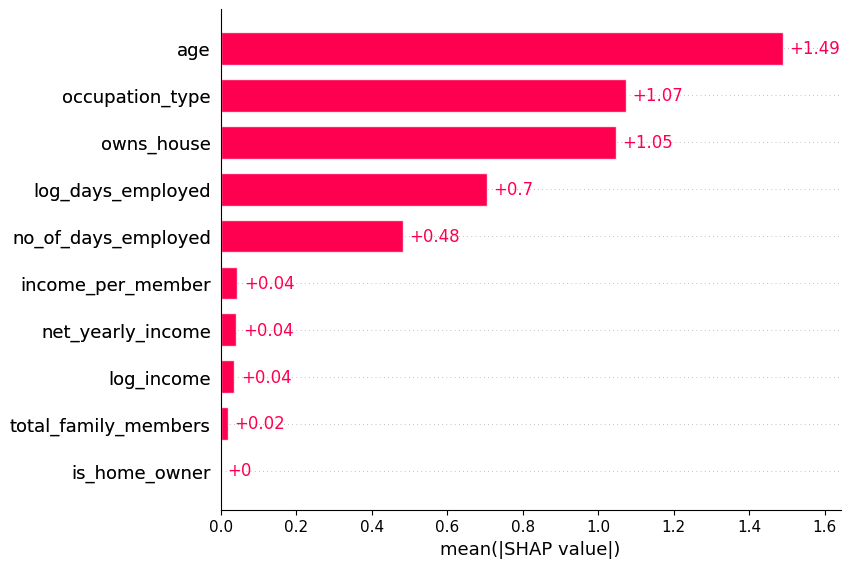

In [86]:
import shap
# Replace X_val with the feature names
explainer = shap.Explainer(model_new_A)
shap_values = explainer(X_val)

# Use feature names for SHAP plot
#shap.summary_plot(shap_values)
shap.plots.bar(shap_values)

We can try to remove some least impactful features to see the model performance, such as is_home_owner, total_family_members,log_income, net_yearly_income, and income_per_member.

In [65]:
# Model B
# We can update the model by removing least useful features.
basic_features=['age', 'occupation_type', 'no_of_days_employed','owns_house']
X_new = df[basic_features].copy()
y_new = df['credit_card_default']

# Log transform to reduce skewness
#X_new['log_income'] = np.log1p(X_new['net_yearly_income'])
#X_new['log_days_employed'] = np.log1p(X_new['no_of_days_employed'])

# Income per family member
#X_new['income_per_member'] = X_new['net_yearly_income'] / (X_new['total_family_members'] + 1)

from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Impute missing
imputer = SimpleImputer(strategy='median')
#X_imputed = imputer.fit_transform(X_new)
# Reassign feature names after imputation
X_imputed = pd.DataFrame(imputer.fit_transform(X_new), columns=X_new.columns)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y_new)

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42)


model_new_B = LGBMClassifier(class_weight='balanced', random_state=42)

model_new_B.fit(X_train, y_train)
y_pred_new = model_new_B.predict(X_val)
y_prob_new = model_new_B.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_pred_new))
print("New User AUC:", roc_auc_score(y_val, y_prob_new))


[LightGBM] [Info] Number of positive: 33465, number of negative: 33464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 66929, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      8367
           1       1.00      0.88      0.93      8366

    accuracy                           0.94     16733
   macro avg       0.94      0.94      0.94     16733
weighted avg       0.94      0.94      0.94     16733

New User AUC: 0.9590688331071707


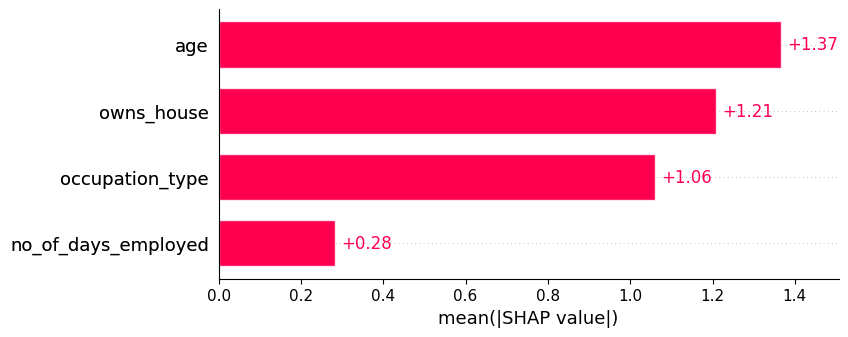

In [66]:
explainer = shap.Explainer(model_new_B)
shap_values = explainer(X_val)

# Use feature names for SHAP plot
#shap.summary_plot(shap_values)
shap.plots.bar(shap_values)

### Compare Model A and B
| Metric                | Model A (10 features)                                       | Model B (4 features)                                          |
| --------------------- | ----------------------------------------------------------- | ------------------------------------------------------------- |
| **AUC**               | 0.963                                                       | 0.959                                                         |
| **Accuracy**          | 0.95                                                        | 0.94                                                          |
| **F1 (Default = 1)**  | 0.95                                                        | 0.93                                                          |
| **Top SHAP Features** | `age`, `occupation_type`, `owns_house`, `log_days_employed` | `age`, `owns_house`, `occupation_type`, `no_of_days_employed` |

✅ Insights:

Model A includes engineered features (log_income, log_days_employed, income_per_member, is_home_owner) and gives slightly better AUC and F1.

Model B uses fewer raw features—this may be more explainable and generalizable but has a very small drop in performance. Surprisingly,net_yearly_income does not impact too much on the model performance which seems contradict to common sense.

SHAP shows that age, occupation_type, and owns_house are consistently impactful across both models.

If we go back to check the orinal train data, we can see net_yearly_income is number, we don't know whether exactly the data come from solid source or input by customer. If inputed by customer, this number may not be very responsible. While occupation_type is categoried and owns_house is yes or no. These may imply when collect the customer information for risk assessment, we better give them choices rather than ask for inputting by themselves.

📌 Recommendation:

If we're optimizing for explainability and deployment simplicity, Model B is acceptable.

If we want maximum performance for internal risk control, Model A is better.






Let's analyze the Model A performance (We want to maximum performance for risk control):

✅ Overall Strengths

| Metric               | Value        | Comment                                                                           |
| -------------------- | ------------ | --------------------------------------------------------------------------------- |
| **AUC**              | 0.963        | Excellent model performance – strong ability to rank risky vs non-risky customers |
| **Accuracy**         | 0.95         | High overall classification accuracy on balanced validation set                   |
| **Balanced Samples** | 8367 vs 8366 | Evaluation conducted on a 50/50 resampled dataset – good for model comparison     |


🔍 Per-Class Analysis

Class 0 – Non-Default

| Metric        | Value | Comment                                                                 |
| ------------- | ----- | ----------------------------------------------------------------------- |
| **Precision** | 0.91  | 9% of predicted non-defaults were actually defaulters (false negatives) |
| **Recall**    | 1.00  | Perfect detection of actual non-defaulters                              |
| **F1-Score**  | 0.95  | Excellent overall performance for safe customers                        |
                            |

Class 1 – Default

| Metric        | Value | Comment                                                        |
| ------------- | ----- | -------------------------------------------------------------- |
| **Precision** | 1.00  | No false positives – all predicted defaulters were truly risky |
| **Recall**    | 0.90  | Missed 10% of actual defaults – relatively small risk exposure |
| **F1-Score**  | 0.95  | Very strong identification of defaulting users                 |



⚠️ Potential Limitations

| Limitation                               | Description                                                                                     |
| ---------------------------------------- | ----------------------------------------------------------------------------------------------- |
| **Recall < 1.00 for Class 1**            | 10% of actual defaulters went undetected – may result in financial risk if not further analyzed |
| **Evaluation on Resampled Data**         | Real-world datasets are imbalanced. Model may not perform as well on naturally skewed data.     |
| **Overconfidence in Default Prediction** | Precision = 1.00 can suggest conservative thresholding – may miss borderline risky customers    |


We want to know this model meet the real credit risk assessment.

📊 Industry Benchmark: Credit Card Default Rates

In the credit card industry, typical default (delinquency) rates are:

| Credit Card Segment     | Typical Default Rate     |
| ----------------------- | ------------------------ |
| Prime (Good Credit)     | \~1% – 3%                |
| Subprime (Low Credit)   | \~5% – 15%               |
| During Financial Crises | >15% (historical spikes) |

📈 Business Risk Implication (American Express Context)
If the default base rate is ~2% and the model A misses 10% of these, the uncontrolled risk exposure becomes:

2% (base rate) × 10% (false negative rate) = 0.2% unmitigated default risk

This is well within acceptable business limits for a credit card issuer like Amex, assuming standard interest rates and collections mechanisms are in place.

✅ Final Assessment

This model is suitable for new users in a credit card setting.
It performs better than many baseline scoring systems in the industry.

## Phase 2: Build Level 2 – Existing User Model

For existing user we can have more features from the previous credit history, now we can add more features to build existing user model.

In [46]:
# === Step 1: Select features, we use all features
behavioral_features = [
    'age', 'net_yearly_income', 'occupation_type', 'no_of_days_employed', 'owns_house', 'total_family_members',
    'credit_limit', 'credit_limit_used(%)', 'credit_score',
    'yearly_debt_payments', 'prev_defaults', 'default_in_last_6months'
]

X_exist = train[behavioral_features].copy()
y_exist = train['credit_card_default']

# === Step 2: Encode categorical
from sklearn.preprocessing import LabelEncoder
for col in X_exist.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_exist[col] = le.fit_transform(X_exist[col].astype(str))

# === Step 3: Feature Engineering
#X_exist['log_income'] = np.log1p(X_exist['net_yearly_income'])
#X_exist['log_days_employed'] = np.log1p(X_exist['no_of_days_employed'])
X_exist['income_per_member'] = X_exist['net_yearly_income'] / (X_exist['total_family_members'] + 1)
#X_exist['is_home_owner'] = X_exist['owns_house'].map({1: 1, 0: 0})

# === Step 4: Impute missing
imputer = SimpleImputer(strategy='median')
X_imputed_exist = pd.DataFrame(imputer.fit_transform(X_exist), columns=X_exist.columns)

# === Step 5: Handle imbalance
smote = SMOTE(random_state=42)
X_resampled_exist, y_resampled_exist = smote.fit_resample(X_imputed_exist, y_exist)

# === Step 6: Train/Test split
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_resampled_exist, y_resampled_exist, stratify=y_resampled_exist, test_size=0.2, random_state=42
)

# === Step 7: Train model
model_exist = LGBMClassifier(class_weight='balanced', random_state=42)
model_exist.fit(X_train2, y_train2)

# === Step 8: Evaluate
y_pred2 = model_exist.predict(X_val2)
y_prob2 = model_exist.predict_proba(X_val2)[:, 1]

print(classification_report(y_val2, y_pred2))
print("Updated Existing User AUC:", roc_auc_score(y_val2, y_prob2))


[LightGBM] [Info] Number of positive: 33465, number of negative: 33464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 66929, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8367
           1       0.99      0.99      0.99      8366

    accuracy                           0.99     16733
   macro avg       0.99      0.99      0.99     16733
weighted avg       0.99      0.99      0.99     16733

Updated Existing User AUC: 0.9996420057040795


In [90]:
expected_existing_user_columns = X_train2.columns.tolist()
joblib.dump(expected_existing_user_columns, "expected_existing_user_columns.pkl")
print(expected_existing_user_columns)

['age', 'net_yearly_income', 'occupation_type', 'no_of_days_employed', 'owns_house', 'total_family_members', 'credit_limit', 'credit_limit_used(%)', 'credit_score', 'yearly_debt_payments', 'prev_defaults', 'default_in_last_6months', 'income_per_member']


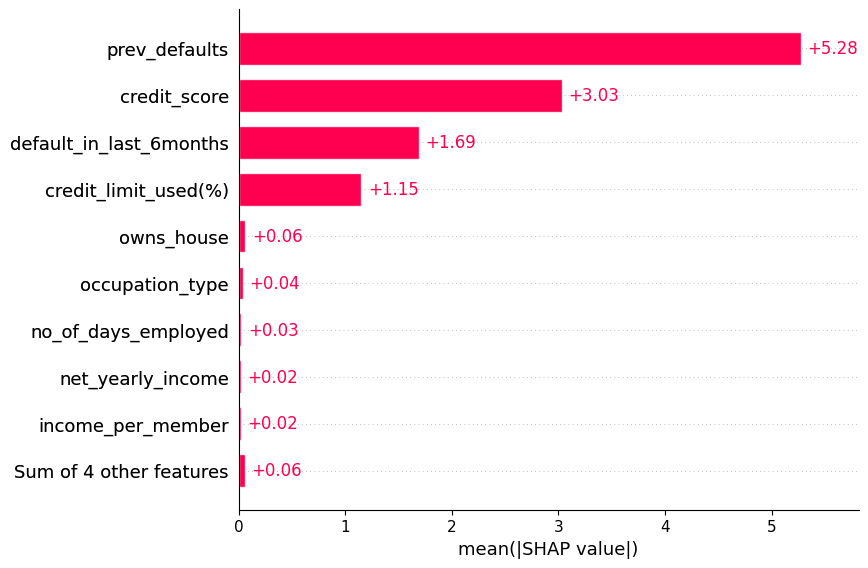

In [47]:
explainer = shap.Explainer(model_exist)
shap_values = explainer(X_val2)

shap.plots.bar(shap_values)

✅ Model Strengths

Outstanding Overall Performance

Accuracy: 0.99

Precision (0/1): 0.99 / 0.99

Recall (0/1): 0.99 / 0.99

AUC: 0.9996

This means the model can almost perfectly distinguish between default and non-default cases.

High Recall for Class 1 (Default)

Recall = 0.99 → Very few actual defaulters are missed (low false negatives), which is critical in credit risk modeling.

Balanced Precision and Recall

Indicates that both false positives and false negatives are well-controlled.

Robust SHAP Feature Interpretation

Key Drivers: prev_defaults, credit_score, default_in_last_6months, credit_limit_used(%)

SHAP clearly explains model behavior, with features showing strong positive contribution toward predicting defaults.

⚠️ Potential Limitations or Considerations

Overfitting Risk

Given such high performance on validation,  we should validate the model on unseen test data or via cross-validation to ensure it's not overly tuned to training/validation data.

Data Leakage

Strong signals like prev_defaults and default_in_last_6months may reflect post-loan behavior, which isn’t available at initial approval.

These features are more suitable for early-warning models, not application-time models.

Operational Realism

If this model is used at credit card issuance, make sure all input features are known before user becomes a customer.

For example, credit_limit_used(%) is not available for new applicants.

📊 Summary

| Metric           | Score  |
| ---------------- | ------ |
| Accuracy         | 0.99   |
| Recall (Def.)    | 0.99   |
| Precision (Def.) | 0.99   |
| AUC              | 0.9996 |

If used for existing user monitoring, this model is very strong and business-ready.

### Build A Credit Risk Assessment Demo with Streamlit



In [67]:
# Save the trained model for new user and existing user.
joblib.dump(model_new_A, "new_user_model")
joblib.dump(model_exist, "existing_user_model")# Download the model and upload to github for deploying on Streamlit

['existing_user_model']

🔍 Model Analysis & Limitations

1.Lack of Deep Feature Differentiation
Our current credit risk models (for both new and existing users) are trained on the available features in the dataset without deeper segmentation or interaction modeling. For example:

We treat occupation_type as a flat categorical variable via one-hot encoding or label encoding, but do not explore the risk differences across occupation types (e.g., stable government jobs vs. seasonal labor).

Features like owns_house, age, and total_family_members are treated independently, with no interaction terms or nonlinear relationships considered.

We haven't modeled how the effect of age might differ across income levels or how housing ownership interacts with family structure.

2.Limited Feature Interpretability
Although LightGBM provides high performance, its predictions can be hard to interpret without tools like SHAP. Preliminary observations (e.g., from feature importance or decision tree paths) suggest:

Older users sometimes have higher predicted default risk, which may be due to assumptions encoded in the data (e.g., low or no income, longer credit history).

Owning a house may not reduce default risk as strongly as expected if other variables like income or debt payments dominate the signal.

Interestingly, fewer family members might be associated with lower default risk—this may reflect lower living costs or financial responsibilities, but more investigation is needed.

These insights point to the need for causal reasoning or explainability tools (like SHAP, LIME) to better understand the model's logic.

3.Real-World Fintech Context Missing
In a real fintech credit system, users are allowed (and often encouraged) to submit documentation to improve their approval chances. These include:

- Identity verification (e.g., facial recognition, ID card)

- Proof of income or employment

- House/property ownership certificates

- Bank statements or tax returns

However, our demo:

- Only includes structured data already present in the training dataset.

- Does not include dynamic document submission or verification flows.

- Lacks simulation of user-driven behavior (e.g., updating information to improve credit score or reduce risk).

Thus, while our demo mimics the decision pipeline, it lacks the complex logic and interaction seen in real production systems.

4.Opportunities for Enhancement

To build a more robust credit risk platform:

Introduce user interaction design for submitting documents or additional info.

Build confidence-based thresholds where users can reduce risk through verified submissions.

Use multi-source data fusion (e.g., open banking APIs, credit bureau scores).

Expand to time-series analysis for repayment history and behavior modeling.

💡 Real-World Extension: Credit Limit Modeling

In actual fintech credit systems, it's not just about whether to approve a user, but also how much credit to assign. This involves a more comprehensive framework:

Probability of Default (PD): Modeled in our notebook.

Credit Limit Assignment: Determines the borrowing cap a user is eligible for.

Loss Given Default (LGD) and Exposure at Default (EAD): Often used in expected loss calculations.

Example:

- A low-risk user may be offered a $10,000 credit limit.

- A higher-risk user might only be offered $500, or even denied.

These models often require:

- Longer behavioral data history

- External credit bureau integration

- Advanced techniques like regression, multi-task learning, or even reinforcement learning

This notebook serves as a simplified demonstration of credit default prediction, and can be extended further for more realistic credit scoring, credit limit assignment, and dynamic decision-making systems in fintech.